In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

Importing plotly failed. Interactive plots will not work.


In [4]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [5]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [6]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2017',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [7]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [8]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x147b9c700>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x147b9f490>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x147b9fa90>)],
                  verbose=True)

In [12]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [13]:
features_config_get = {}

In [14]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'], #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard'],
    'axis': 'columns',
    'shift': range(1, 7, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(7, 14, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr':0.65,
    'data_dir': root_dir / 'data',
    'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0]
    #'target_bins': [0, 0.97, 1.0]
    }

In [15]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-06 18:13:21,122: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-06 18:13:21,195: INFO: Initialisation des features
root 2024-11-06 18:13:21,197: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-11-06 18:13:21,458: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-11-06 18:13:21,782: INFO: Getting the dataset from 01-01-2019 to 30-12-2023 for [<src.location.location.Location object at 0x14776b250>]
root 2024-11-06 18:13:21,951: INFO: Getting data for hospitalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-06 18:13:21,961: INFO: Augmentation des features...
root 2024-11-06 18:13:21,986: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-06 18:13:21,998: INFO: Augmentation des features...
root 2024-11-06 18:13:22,091: INFO: Creating the target columns as a rolling mean of nb_emmergencies_CHU Dijon on 3 rows shift

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped 0 constant columns from both sets: []
X shape: (1162, 99), y shape: (1162, 1)
            target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J
date                                                      
2019-01-03                                             2.0
2019-01-04                                             2.0
2019-01-05                                             2.0
2019-01-06                                             3.0
2019-01-07                                             3.0
...                                                    ...
2022-03-05                                             3.0
2022-03-06                                             3.0
2022-03-07                                             3.0
2022-03-08                                             3.0
2022-03-09                                             3.0

[1162 rows x 1 columns]
[ColumnTransformer] .... (1 of 3) Processing

In [16]:
df = arsTabularDataset.y_train

# Identifie les colonnes contenant des NaN
cols_with_nan = df.columns[df.isna().any()].tolist()
print("Colonnes contenant des NaN:", cols_with_nan)

# Affiche la liste des index des lignes contenant des NaN pour chaque colonne
nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
nan_indices

Colonnes contenant des NaN: []


{}

In [17]:
df

,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J
date,
2019-01-03,2.0
2019-01-04,2.0
2019-01-05,2.0
2019-01-06,3.0
2019-01-07,3.0
...,...
2022-03-05,3.0
2022-03-06,3.0
2022-03-07,3.0


In [18]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
model_params = {
    'early_stopping_rounds': 10,
    # 'eval_set': [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)], # TODO: to be set in the experiment's run method
    'verbosity': 0,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree' 
}

In [19]:
metrics = ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] # first one is used for evaluation and everywhere a sinlge metric is used, the rest are used for testing

In [20]:
# Create the model
model = get_model(model_type='xgboost', name='XGBoost', device='cpu', task_type='regression', test_metrics=metrics, params=model_params)

In [21]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model)

In [22]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 5, 7, 9, 11],
}

In [23]:
fit_params = {
    'verbose': 0,
}

In [24]:
model_config={"optimization": "grid", "grid_params": grid_params, "fit_params": fit_params}

2024/11/06 18:13:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/11/06 18:13:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-11-06 18:13:23,397: INFO: Running the experiment...
root 2024-11-06 18:14:07,447: INFO: Model fitted.
root 2024-11-06 18:14:19,009: INFO: Scoring the model...
root 2024-11-06 18:14:19,076: INFO: Testing the model...
root 2024-11-06 18:14:19,143: INFO: Plotting the results...
matplotlib.legend 2024-11-06 18:14:19,181: WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024/11/06 18:14:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_4 at: http://127.0.0.1:8080/#/experiments/919456489328722199/runs/cd17bd2ac84f40d886b

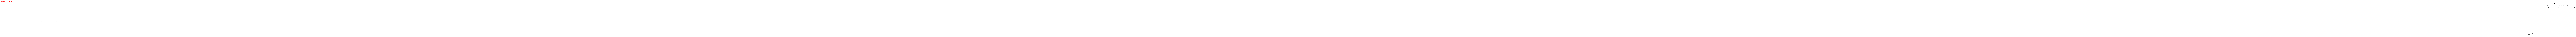

In [25]:
# Run the experiment
ars_experiment.run(dataset_config=dataset_config, model_config=model_config, find_best_features=False)

In [26]:
X_train = ars_experiment.dataset.enc_X_train
X_test = ars_experiment.dataset.enc_X_test
X_val = ars_experiment.dataset.enc_X_val

y_train = ars_experiment.dataset.y_train
y_test = ars_experiment.dataset.y_test
y_val = ars_experiment.dataset.y_val

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

In [27]:
# model = ars_experiment.model

In [28]:
# dataset = arsTabularDataset

In [29]:
# dataset.enc_data.head()

In [30]:
# df = dataset.enc_data
# df

In [31]:
# from scipy.cluster import hierarchy
# from scipy.spatial.distance import squareform
# from scipy.stats import spearmanr
# import matplotlib.pyplot as plt
# import numpy as np

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# corr = spearmanr(X).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

In [32]:
# from shap_select import shap_select

In [33]:
# selected_features_df = shap_select(model.best_estimator_, X_val, y_val, task="regression", threshold=0.05)

In [34]:
# X_train

In [35]:
# bst = model.best_estimator_.get_booster()

In [36]:
# importance_gain = bst.get_score(importance_type='gain')
# importance_cover = bst.get_score(importance_type='cover')
# importance_weight = bst.get_score(importance_type='weight')

In [37]:
# df_cover = pd.DataFrame(importance_cover, index=[0]).T
# df_gain = pd.DataFrame(importance_gain, index=[0]).T
# df_weight = pd.DataFrame(importance_weight, index=[0]).T

In [38]:
# df_cover.shape

In [39]:
# df_cover.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_gain.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_weight.sort_values(by=0).plot(kind="barh", figsize=(15,20))

In [40]:
# model.shapley_additive_explanation(X_test, outname='shap_b', dir_output='.', mode="beeswarm", figsize=(500000, 200000))

In [41]:
# from collections import defaultdict

# cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# selected_features_names = X.columns[selected_features]
# X_train_sel = X_train[selected_features_names]
# X_test_sel = X_test[selected_features_names]
# X_val_sel = X_val[selected_features_names]
# model_config['fit_params'].update({'eval_set': [(X_val_sel, y_val[target]) for target in ars_experiment.dataset.targets_names]})
# model.fit(X_train_sel, y_train, **model_config)
# print(
#     "Baseline accuracy on test data with features removed:"
#     f" {model.score(X_test_sel, y_test):.2}"
# )


In [42]:
# import matplotlib

# from sklearn.inspection import permutation_importance
# from sklearn.utils.fixes import parse_version


# def plot_permutation_importance(clf, X, y, ax):
#     result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
#     perm_sorted_idx = result.importances_mean.argsort()

#     # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
#     # renamed to `tick_labels`. The following code handles this.
#     tick_labels_parameter_name = (
#         "tick_labels"
#         if parse_version(matplotlib.__version__) >= parse_version("3.9")
#         else "labels"
#     )
#     tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
#     ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
#     ax.axvline(x=0, color="k", linestyle="--")
#     return ax


In [43]:
# fig, ax = plt.subplots(figsize=(7, 6))
# plot_permutation_importance(model, X_test_sel, y_test, ax)
# ax.set_title("Permutation Importances on selected subset of features\n(test set)")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()
# plt.show()

In [44]:
# get the first line of x train
# X_train_sel[:1]

In [45]:
# y_train[:1]

In [46]:
# model.predict(X_train_sel[:1])

In [47]:
# import shap
# shap.initjs()
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)
# single_explanation = explainer_xgb.shap_values(X_train_sel[:1])
# shap.summary_plot(single_explanation, X_test_sel, plot_type="bar")


In [48]:
# X_train.columns

In [49]:
# model = ars_experiment.model

In [50]:
# X_train = ars_experiment.dataset.enc_X_train
# X_test = ars_experiment.dataset.enc_X_test
# X_val = ars_experiment.dataset.enc_X_val

# y_train = ars_experiment.dataset.y_train
# y_test = ars_experiment.dataset.y_test
# y_val = ars_experiment.dataset.y_val

In [51]:
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)

In [52]:
# X_train

In [53]:
# shap_values_xgb = explainer_xgb.shap_values(X_train)


In [54]:
# shap.plots.force(explainer_xgb.expected_value, shap_values_xgb)

In [55]:
# shap.dependence_plot('inc_grippe', shap_values_xgb, X_train_sel)

In [56]:
# shap_values_xgb